# Introduction to Physics Informed Neural Networks (PINNs)

PINNs refer to a class of supervised deep learning algoritms which regulizes the learning with pyhsics by means of incorparating the governing partial differantial equations (PDE) of the respective physics. 

A general nonlinear partial differential equation can be expressed as:
$$
\dot{u} + N_\lambda[u]=0, \quad x \in \Omega, \quad t \in[0, T],
$$


where $u = \hat{u}(t,x)$, represents the hidden solution, here $\hat{[\cdot]}$ is used to seperate solution from its value, $\dot{u}$ is the partial derivative wrt time, $N_\lambda$ is a nonlinear operator that dependents on the parameter $\lambda$, and $\Omega$ is a subset of $\mathbb{R}^{D}$. A large set of physical phenomenon, such as conservation laws, diffusion processes, advection-diffusion models, and kinetic equations can be formulated by this equation. 


Neural networks can be universal approximators given sufficient depth and width, and PINNs leverage this idea with the governing partial differential equtions to provide framework to:

- Approximate the solutions of PDEs (Forward Problems)
- Discover the underlying PDEs (Inverse Problems)
- Learn the solution operator of parametric PDEs (Parametric Problems)


## Toy Problem

Lets define a toy problem to follow these usecases. This example is inspired from Ben Moseley, you can check his blog post about PINNs here: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

We consider a homogeneous soil layer. The dynamic response of a single layer soil can be simplified to be:

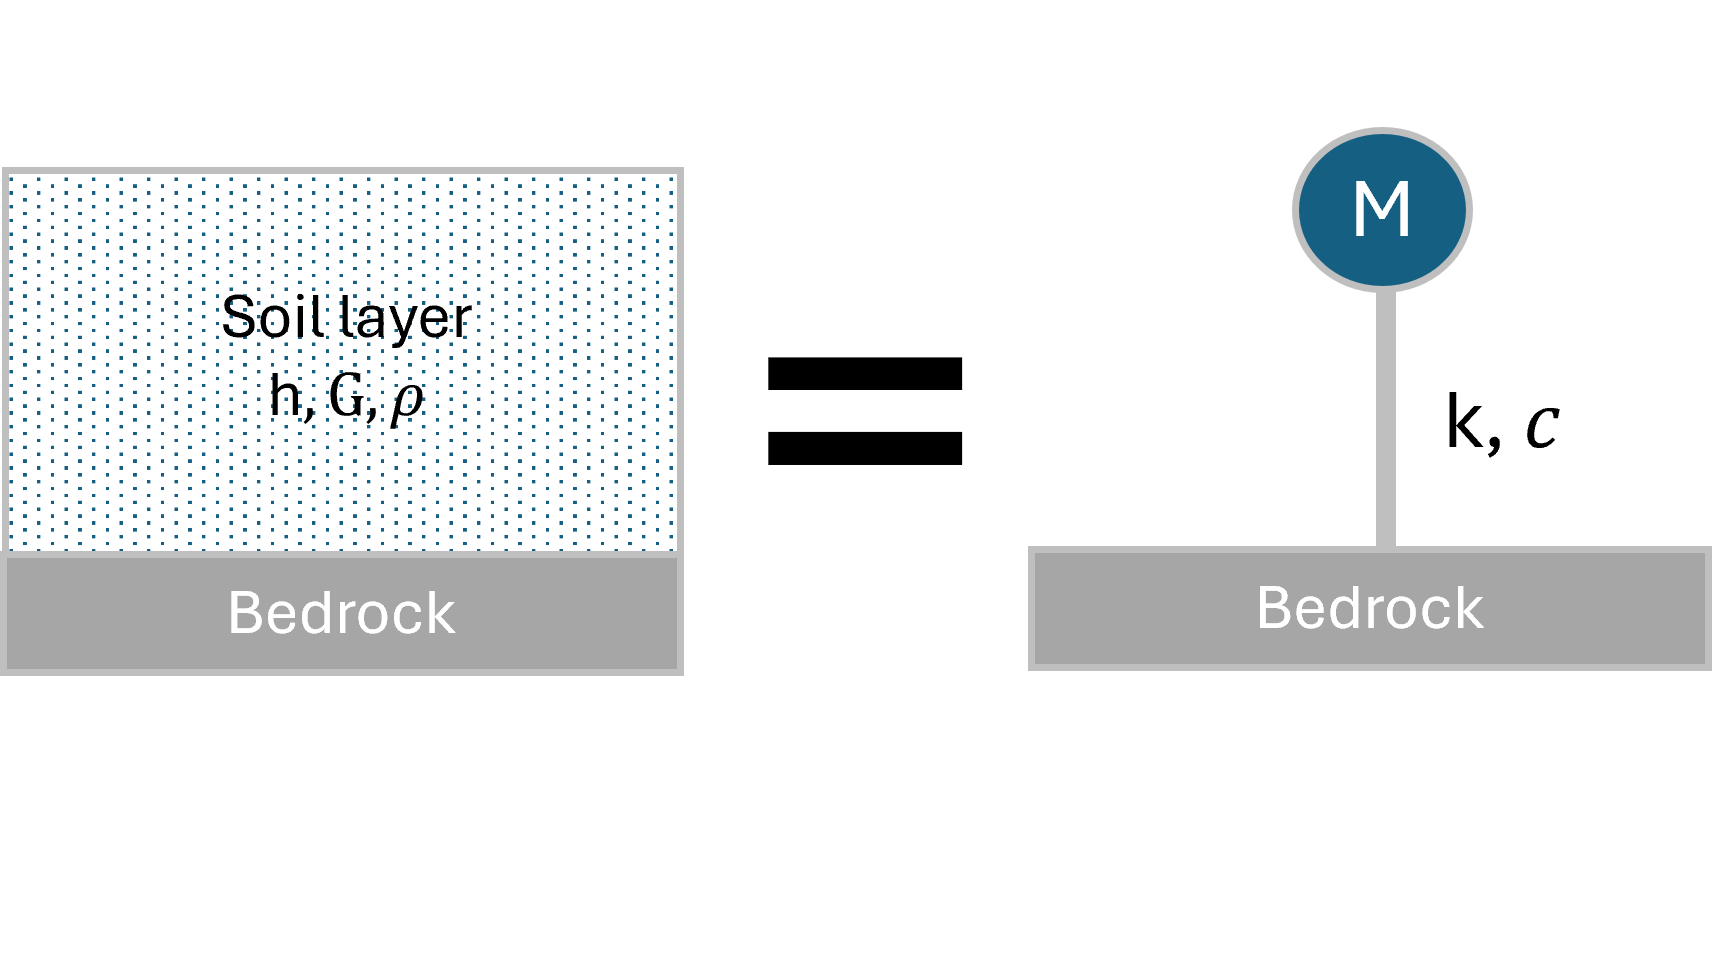

The 1 dimensional dynamic response of a homogenous soil layer can be represented by the 2nd order ordinary differential equation as:

$$
\ddot{u}(t) + 2\zeta\omega_0\dot{u}(t) + \omega_0^2u = - a_g~,
$$
with
$$
\omega_0 = \sqrt{\dfrac{k}{m}};\quad\quad \zeta = \dfrac{c}{2\,m\,\omega_0},
$$

where $u$, $\dot{u}$, $\ddot{u}$, $m$, $c$, $k$, are the horizontal displacement, velocity, acceleration, mass, damping coefficient and stiffness of the soil layer respectively, lastly $a_g$ is the acceleration at the base of the soil layer. 

Lets simplify this even more and assume a case where $a_g = 0$ with the initial conditions

$$
u(0) = 1~~,~~\dot{u}(0) = 0~.
$$

Then the equation becomes homogenous and for the underdamped case the exact solution can be written as

$$
u(t) = e^{-\zeta\omega_0 t}[\dfrac{\zeta \omega_0}{\omega_d} \sin(\omega_d t)+ \cos(\omega_d t)]~,~~~~~\mathrm{with}~~\omega_d=\omega_0\sqrt{1-\zeta^2}~.
$$

### Problem Setup: Parameters and Domain
Now we can define the parameters and the domain for the problem as follows:  
Damping coefficient ($\zeta$): 0.1  
Natural frequency ($\omega_0$): 20 Hz  
Time domain ($t$): [0, 1]

We will now try to approximate the solution of this governing differential eqaution using PINNs.

## Solution of Partial Differential Equations

Solution of PDEs refers to computing the hidden state $u(t,x)$ that fulfills the general partial differential equation for a given conditions and fixed $\lambda$. PINNs can approximate this solution, $\hat{u}(t, x)$, by finding the neural network $u_\theta$ parametrized by the weights and biasses $\theta$ of the network. 

$$
f(t, x) = \dot{u}_\theta + N[u_\theta],
$$

where $f(t,x)$ is the residual. The solution is approximated by the deep neural network, and automatic differentiation enables the calculation of its derivatives. This residual of the partial differential equations can be added to the loss function to incorporate the physics into the learning process. 

$$
L_{tot} = \lambda_u L_{u} + \lambda_{PDE} L_{PDE}
$$

Where $\lambda_u$ and $\lambda_{PDE}$ are hyperparameters that control the contribution of each loss term, $L_u$ and $L_{PDE}$. $L_u$ represents the supervised data loss and $L_{PDE}$ represents the unsupervised physics loss. They can be stated generally as:

$$
L_u = \frac{1}{N_u}\sum_{i=1}^{N_u}\Vert {u_\theta(t^i, x^i) - u^i}\Vert
$$
measures the discrepancy between the PINN approximation $u_\theta(t, x)$ and the given boundary and measurement data on the set $\Gamma$
$$
L_{PDE} = \frac{1}{N_{PDE}}\sum_{k=1}^{N_{PDE}}\Vert {f(t^k, x^k)}\Vert
$$
is the calculation of the residuals with an arbitrary metric $\Vert \cdot \Vert$, for the set of collocation points sampled in the domain $\Omega$

In [10]:
# Impoting the required modules
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

We create a function to calculate the analytical solution of the problem. Then we can use this to create syntetic data for training.

In [11]:
def analytical_solution(zeta, omega_0, t):
    "Damped oscillator analytical solution"
    omega_d = omega_0 * np.sqrt(1 - zeta**2)
    A = zeta * omega_0 / omega_d
    B = 1
    return torch.exp(-zeta * omega_0 * t) * (A * torch.sin(omega_d * t) + B * torch.cos(omega_d * t))

In [ ]:
def create_gif(output_path, image_paths, fps=5, loop=0):
    "Generates a GIF from a sequence of image paths"
    frames = [Image.open(p) for p in image_paths]
    frames[0].save(fp=output_path, format='GIF', append_images=frames[1:], save_all=True, duration=int(1000/fps), loop=loop)

Here we are setting the device for PyTorch tensors. Training on GPU is not always faster. Factors such as model size, batch size etc. can make the overhead of transferring data between CPU and GPU outweight the benefits of parallel computation. It is usaually faster to use CPU for simple problems. 

In [13]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


We now define the problem parameters, and training points

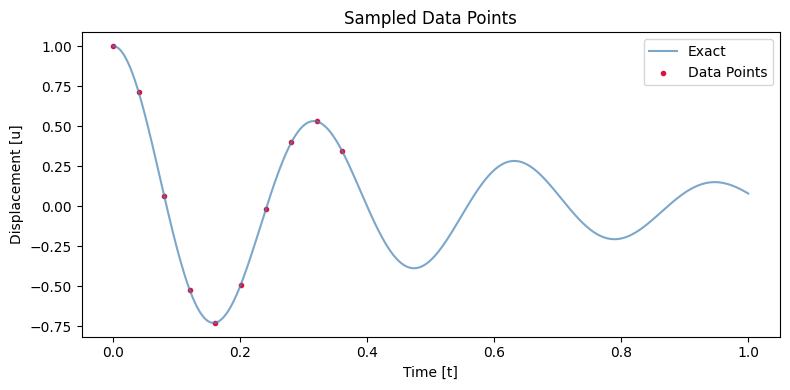

In [14]:
# Parameters
damping = 0.1
omega_n = 20

# Exact data generation, 500 linearly spaced t values
t_vals = torch.linspace(0, 1, 500).view(-1, 1)
u_exact = analytical_solution(damping, omega_n, t_vals)

# Select the every 20th element from the first 200 elements for training
t_train = t_vals[0:200:20]
u_train = u_exact[0:200:20]

# Plot the sampled points
plt.figure(figsize=(8, 4))
plt.plot(t_vals, u_exact, label="Exact", linestyle="-", color="steelblue", alpha=0.7)
plt.scatter(t_train, u_train, color="crimson", marker=".", label="Data Points")
plt.title("Sampled Data Points")
plt.xlabel("Time [t]")
plt.ylabel("Displacement [u]")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
def visualize_results(t, u_exact, t_train, u_train, u_pred, physics_pts=None, step=None):
    "Visualization of predictions"
    plt.figure(figsize=(8, 4))
    plt.plot(t, u_exact, label="Exact", color="steelblue", linewidth=2)
    plt.plot(t, u_pred, label="NN Prediction", color="black",  linestyle="-", linewidth=3, alpha=0.7)
    plt.scatter(t_train, u_train, label="Training Data", color="crimson", marker=".", s=50)
    if physics_pts is not None:
        plt.scatter(physics_pts, torch.zeros_like(physics_pts), label="Physics Points", color="seagreen", marker='.', s=50)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.2, 1.2)
    plt.xlabel("Time [t]")
    plt.ylabel("Displacement [u]")
    plt.title(f"Epoch {step}")
    plt.legend(loc="upper right")
    plt.tight_layout()

Define a simple feed forward network

In [34]:
# Simple MLP architecture
class MLP(nn.Module):
    def __init__(self, arch, act):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(arch) - 1):
            layers.append(nn.Linear(arch[i], arch[i + 1]))
            if i < len(arch) - 2: 
                layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.model(inputs)

firstly lets try to predict the displacement at the surface using a regular neural network. For this we can define a simple feed dorward network and train it on the syntetic data we just created and use the model to predict further time steps. So the mapping would be scalar to scalar:
$$
t \mapsto u(t)
$$

so 
$$NN(t) \approx u_\theta(t)$$

Network will take a scalar input for time and will output a scalar for displacement. And we define the loss as only data loss using MSE:
$$
L_u = \frac{1}{N_u}\sum_{i=1}^{N_u} ({u_\theta(t^i) - u^i})^2
$$

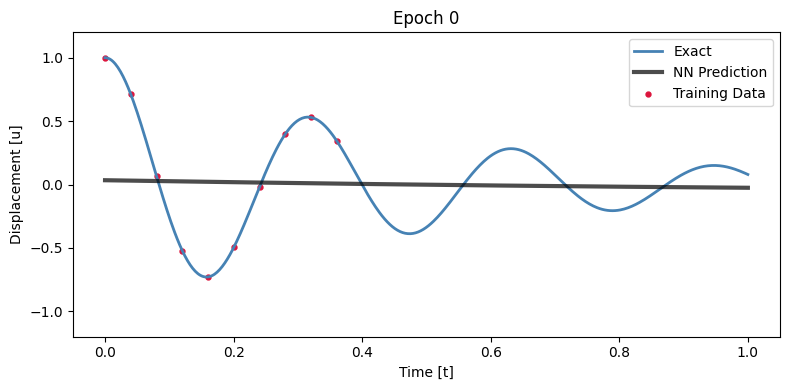

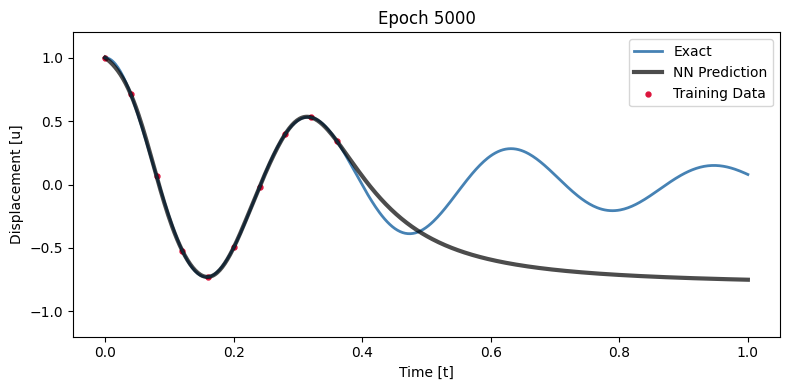

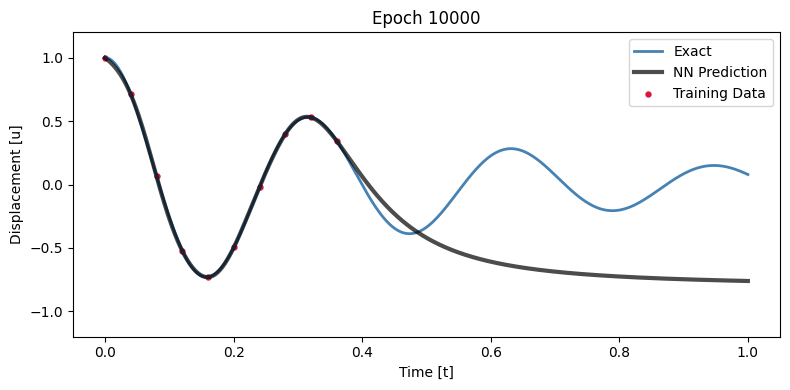

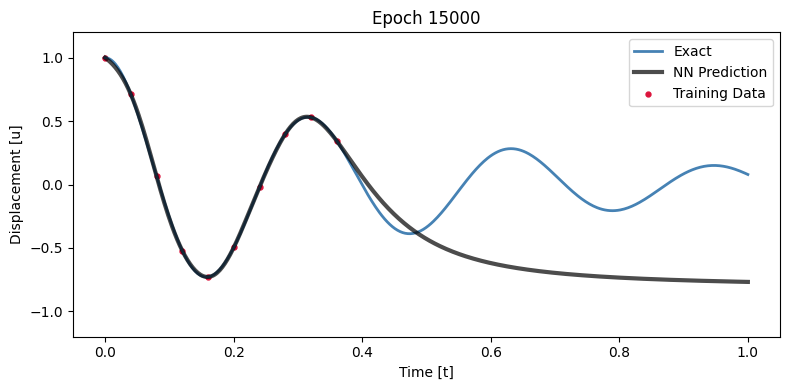

In [35]:
# Train NN without physics
torch.manual_seed(42)
architecture = [1] + [32] * 3 + [1]  # input_dim=1, hidden_dim=32, output_dim=1, depth=3
activation = nn.Tanh # Try different activations like nn.ReLU, nn.Sigmoid, etc.

# we now create the neural network, optimizer
net = MLP(architecture, activation) 
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
img_paths = []

# This creates a directory for saving plots
import os
if not os.path.exists("plots/net"):
    os.makedirs("plots/net")

# Training loop
for step in range(15001):
    optimizer.zero_grad()
    pred_train = net(t_train)  # we are using the previously sampled training data
    loss = nn.functional.mse_loss(pred_train, u_train) # Data loss
    loss.backward()
    optimizer.step()

    if (step) % 100 == 0:
        with torch.no_grad():
            prediction = net(t_vals)
        visualize_results(t_vals, u_exact, t_train, u_train, prediction, step=step)
        filename = f"plots/net/{step:08d}.png"
        plt.savefig(filename, dpi=120, bbox_inches="tight")
        img_paths.append(filename)
        if (step) % 5000 == 0:
            plt.show()
        else:
            plt.close()

create_gif("net_output.gif", img_paths, fps=20)

Network clearly has some troubles predicting the next time steps. We will now incorporate the known physics into the training and see the results. The new network will be very similar to the regular neural network we just defined, but the loss function will be regularized by the governing ODE as well. For this we need to sample extra input points to evaluate the ODE at. The known displacements at these time steps will not be used in the training. Therefore this extra term is unsupervised.

The ODE was:
$$
\ddot{u}(t) + 2\zeta\omega_0\dot{u}(t) + \omega_0^2u = 0~,
$$

Remeber that our Neural network $NN(t) \approx u_\theta(t)$, we rewrite the ODE as:
$$
f  = \frac{\partial^2NN(t)}{\partial t^2} + 2\zeta\omega_0\cdot\frac{\partial NN(t)}{\partial t} + \omega_0^2\cdot NN(t) = 0~,
$$

We can leverage the Automatic Differentiation to calculate the derivatives of the output of NN wrt to the inputs and evaluate the ODE above to calculate the error. So a perfect prediction would mean $f = 0$, then the value of $f$ can be treated as the error of the prediction. And we can use that to regularize the network. 

We can define the extra regularization term as:

$$
L_{PDE} = \frac{1}{N_{PDE}}\sum_{k=1}^{N_{PDE}} ({f(t^k)})^2
$$

Thus the total loss will be:

$$
L_{tot} = \lambda_u L_{u} + \lambda_{PDE} L_{PDE}
$$

$\lambda_u$ and $\lambda_{PDE}$ are coeffcient of each contribution. These have to be defined properly, especially if the scales of the losses are very different. For this problem we take $\lambda_u = 1$ and $\lambda_{PDE} = 1 \times 10^{-4}$

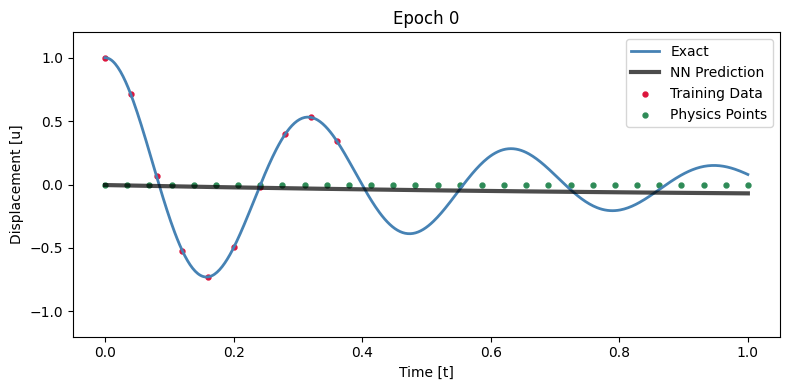

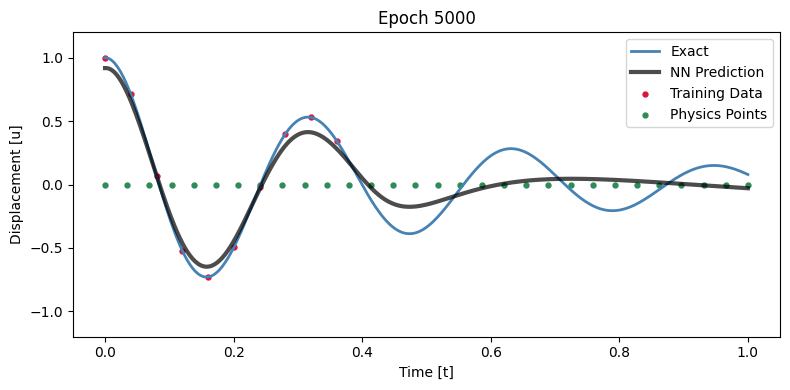

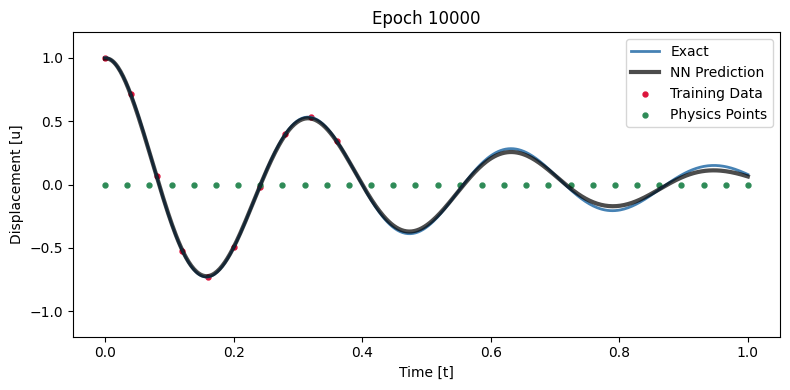

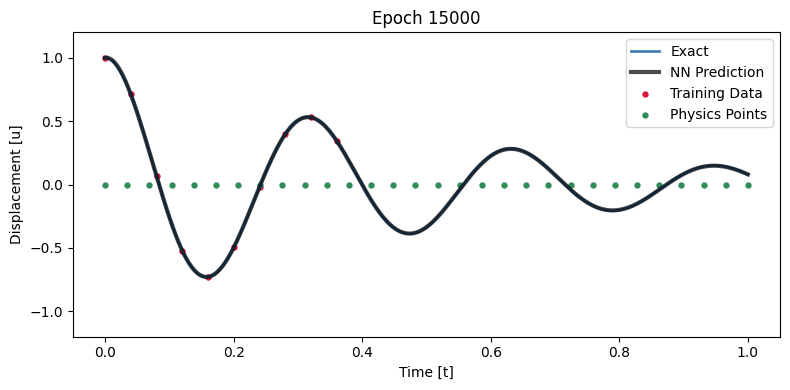

In [36]:
# We are generating 30 extra points to evaluate the physics-informed loss
physics_t = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
torch.manual_seed(42)
# Define the architecture and activation function
architecture = [1] + [32] * 3 + [1]  # input_dim=1, hidden_dim=32, output_dim=1, depth=3

activation = nn.Tanh # Try different activations like nn.ReLU, nn.Sigmoid, etc. and see how it affects the results

net = MLP(architecture, activation)  # Reinitialize the network
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
img_paths = []

if not os.path.exists("plots/pinn"):
    os.makedirs("plots/pinn")

for step in range(15001):
    optimizer.zero_grad()
    
    # Data loss as before
    pred_train = net(t_train)
    loss_data = nn.functional.mse_loss(pred_train, u_train) 

    # Physics-informed loss, evaluated at the physics points
    u = net(physics_t)
    u_t = torch.autograd.grad(u, physics_t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, physics_t, torch.ones_like(u_t), create_graph=True)[0]
    residual = u_tt + 2*damping*omega_n*u_t + omega_n**2 * u # residual of the ODE
    loss_phys = 1e-4 * torch.mean(residual**2) # Physics-informed loss lambda = 1e-4

    total_loss = loss_data + loss_phys # combine the losses
    total_loss.backward()
    optimizer.step()

    if (step) % 100 == 0:
        with torch.no_grad():
            prediction = net(t_vals)
            phys_pts = physics_t.detach()
        visualize_results(t_vals, u_exact, t_train, u_train, prediction, physics_pts=phys_pts, step=step)
        filename = f"plots/pinn/{step:08d}.png"
        plt.savefig(filename, dpi=120, bbox_inches="tight")
        img_paths.append(filename)
        if (step) % 5000 == 0:
            plt.show()
        else:
            plt.close()

create_gif("pinn_output.gif", img_paths, fps=20)

As you cans see, the inclusion of the ODE as a loss term increased the prediction for the unseen time steps. And our PINNs model learned the solution of the ODE, even though we used very few data, in fact it could also learn the solution without any data and we will come to that in a bit. But now we will use PINNs for the discovery of the governing relations. 

## Data-Driven Discovery of Partial Differential Equations

When only noisy and incomplete measurements $z$ are available, the data-driven discovery of PDEs aims to reconstruct the unknown state $u(t,x)$ while simultaneously learning the model parameters $\lambda$ that best describe the observed system. The governing equation is given by:

$$
\dot{u} + N[u; \lambda]=0, \quad x \in \Omega, \quad t \in[0, T]
$$

With the residual function defined as:

$$
f := \dot{u} + N[u; \lambda]=0
$$

and $u(t,x)$ approximated via a deep neural network, the resulting function $f(t,x)$ constitutes a PINN. Automatic differentiation facilitates the derivation of this network. The parameters of $u(t,x)$, $f(t,x)$, and the unknown differential operator parameter $\lambda$ are learned by minimizing the loss function

Lets apply this to our toy problem. 

Let:

$N[u;\lambda]=\lambda_1 \cdot \ddot{u} + \lambda_2 \cdot u$


$$
\dot{u} +\lambda_1 \cdot \ddot{u} + \lambda_2 \cdot u = 0~,
$$

or

$$
f := \dot{u} + N[u; \lambda]=0
$$


So we can let the network learn the parameters $\lambda_1$ and $\lambda_2$

In our case $\lambda=[\lambda_1,\lambda_2]=[\frac{1}{2\zeta\omega_0},\frac{\omega_0}{2\zeta}]=\left[0.25,100.0\right]$

To make it more simple, lets say we know $\omega_0$ already which was 20 and want to find $\zeta$, so:

$\lambda=[\lambda_1,\lambda_2]=[\frac{1}{40\zeta},\frac{20}{2\zeta}]=\left[0.25,100.0\right]$

We have to define a new network in this case with a trainable parameter for damping, we can do that by using `torch.nn.Parameter` to define a trainable parameter in the MLP class. This type of training is called inverse training, so lets call the new network class MLP_inverse

In [39]:
class MLP_inverse(nn.Module):
    def __init__(self, arch, act):
        super(MLP_inverse, self).__init__()
        layers = []
        for i in range(len(arch) - 1):
            layers.append(nn.Linear(arch[i], arch[i + 1]))
            if i < len(arch) - 2: 
                layers.append(act())
        self.model = nn.Sequential(*layers)

        # define a trainable parameter for damping using torch.nn.Parameter
        self.damping = torch.nn.Parameter(torch.tensor(1.))

    def forward(self, inputs):
        return self.model(inputs)

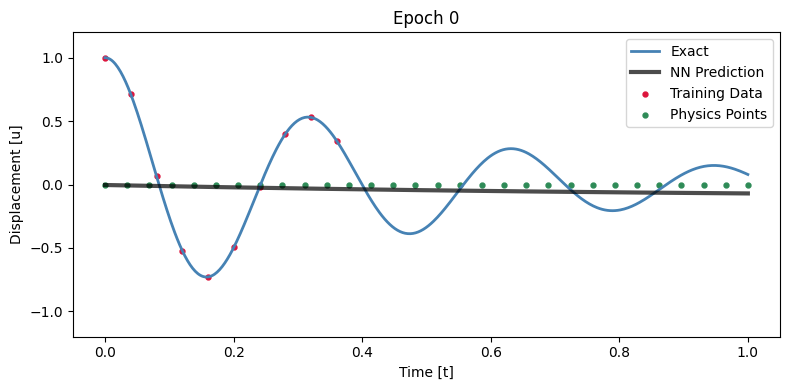

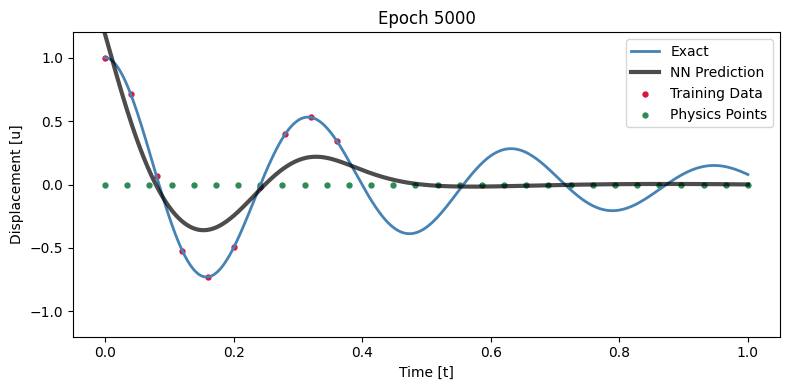

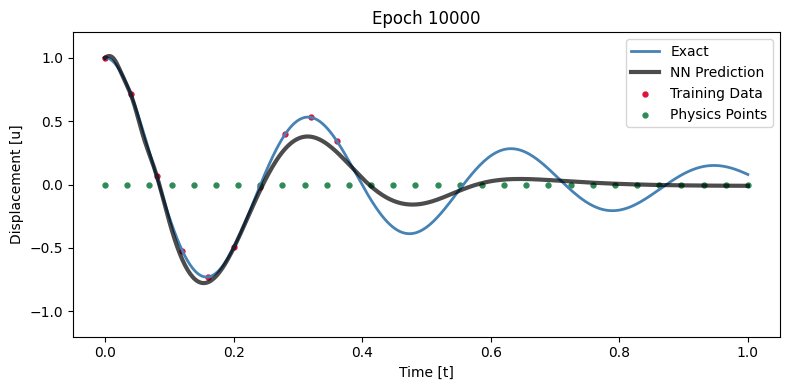

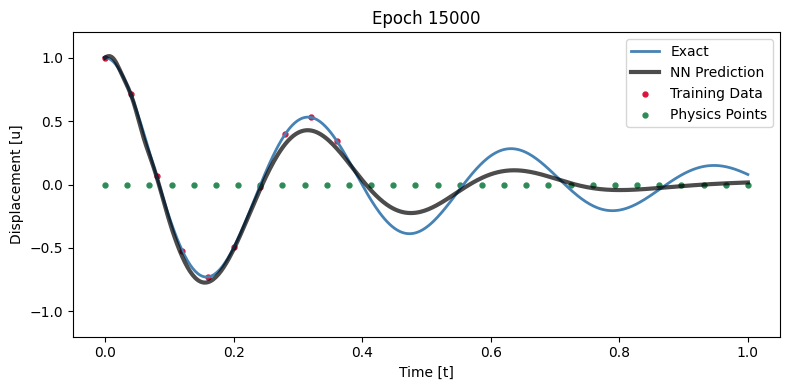

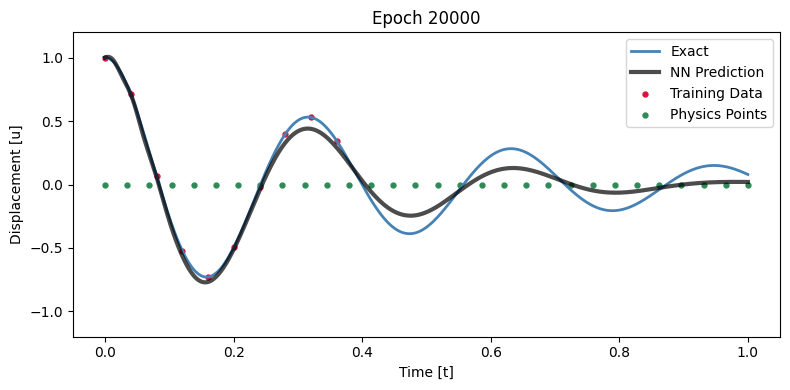

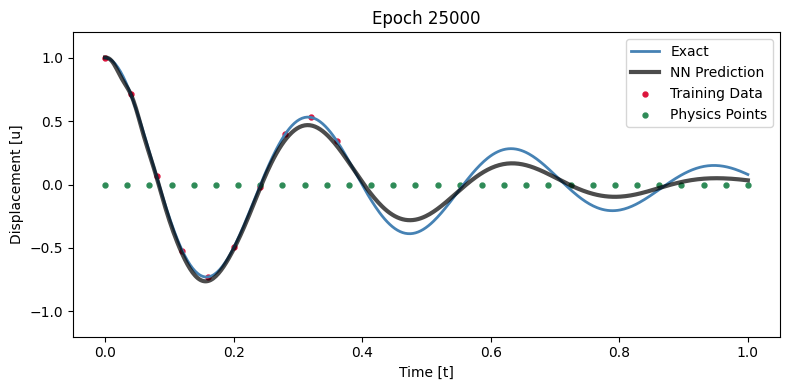

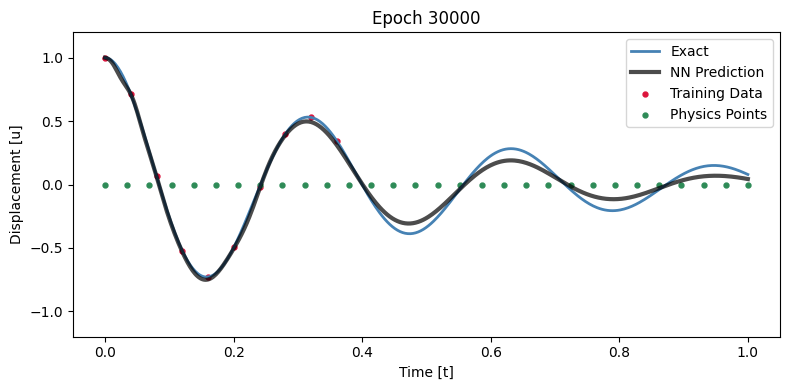

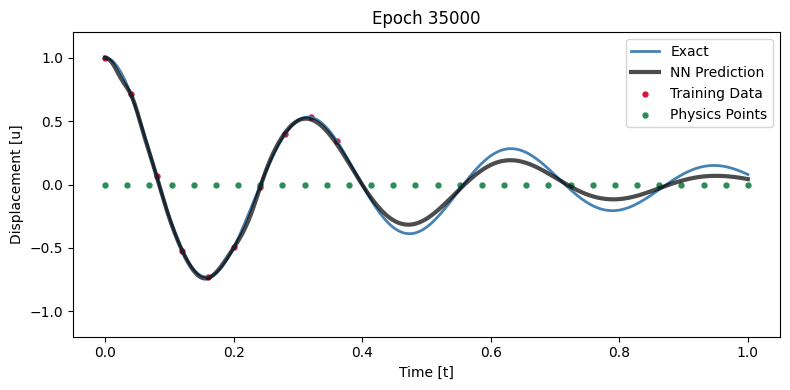

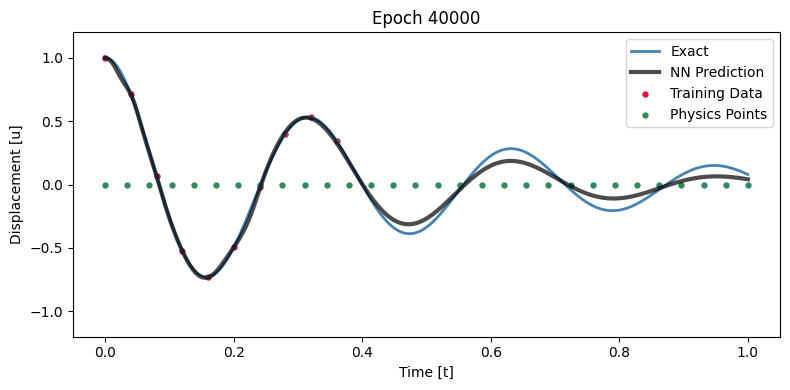

In [40]:
# Train PINN with physics
physics_t = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
torch.manual_seed(42)
# Define the architecture and activation function
architecture = [1] + [32] * 3 + [1]  # input_dim=1, hidden_dim=32, output_dim=1, depth=3
activation = nn.Tanh 
net = MLP_inverse(architecture, activation)  # Reinitialize the network with a trainable damping parameter
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
img_paths = []

# Select the every 5th element from the first 200 elements for training
t_train_inv = t_vals[0:200:20]
u_train_inv = u_exact[0:200:20]

if not os.path.exists("plots/pinn_inv"):
    os.makedirs("plots/pinn_inv")

for step in range(40001):
    optimizer.zero_grad()
    
    # Data loss
    pred_train = net(t_train_inv)
    loss_data = nn.functional.mse_loss(pred_train, u_train_inv)

    # Physics-informed loss
    u = net(physics_t)
    u_t = torch.autograd.grad(u, physics_t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, physics_t, torch.ones_like(u_t), create_graph=True)[0]
    lambda1 = 1 / (2 * net.damping * omega_n)
    lambda2 = omega_n / (2 * net.damping)
    residual = u_t + lambda1 * u_tt + lambda2 * u
    loss_phys = 1e-2 * torch.mean(residual**2)

    total_loss = loss_data + loss_phys
    total_loss.backward()
    optimizer.step()

    if (step) % 100 == 0:
        with torch.no_grad():
            prediction = net(t_vals)
            phys_pts = physics_t.detach()
        visualize_results(t_vals, u_exact, t_train_inv, u_train_inv, prediction, physics_pts=phys_pts, step=step)
        filename = f"plots/pinn_inv/{step:08d}.png"
        plt.savefig(filename, dpi=120, bbox_inches="tight")
        img_paths.append(filename)
        if (step) % 5000 == 0:
            plt.show()
        else:
            plt.close()

create_gif("pinn_inv_output.gif", img_paths, fps=20)

In [22]:
print(f"Final Damping: {net.damping.item():.4f}")
print(f"Final Lambda 1: {lambda1:.4f}, Lambda 2: {lambda2:.4f}")

Final Damping: 0.1120
Final Lambda 1: 0.2232, Lambda 2: 89.2958


As you see, the model is getting better discovering the $\zeta$ with each epoch. Try including more data points and tuning the hyperparameters to improve the accuracy.

## Solving parametric problems with PINNs

So we have seen from the above examples, PINNs can be used as both forward and inverse solvers. However, they offer no significant advantage when the underlying physics is already well known and easily modelled. In such cases, traditional numerical methods are often more efficient and accurate than PINNs. 

Nonetheless, PINNs can outperform classical numerical methods in parametric problems. A parametric problem is one where the governing differential equations depend on certain parameters, meaning the solution of the differential equations vary with different parameter values. In these cases, PINNs can be particularly usefull in learning the mapping from parametes to the solution, which allows for efficient evaluation across a wide range of parameter values.

We can extend the PINNs for this type of problems analogusly. Lets consider the above toy example again but this time we want to also see how different $\zeta$ and $\omega_0$ also changes the solution. So the equation is:

$$ \ddot{u} + 2\zeta \omega_0 \dot{u} + \omega_0^2 u = 0, $$

Here, $\zeta$ and $\omega_0$ are treated as parameters. For each combination of $\zeta$ and $\omega_0$, the system exhibits a different dynamic behavior. To simplify it a bit lets assume $\zeta$ constant and $\omega_0$ is a parameter. One way to solve this using a PINN is to include $\omega_0$ as an additional input to the network, alongside the temporal variable $t$. The network would then learn the mapping:

$$
(t, \omega_0) \mapsto u(t; \omega_0)
$$

There are different ways to parametrize equations, but an easy and good way of doing so is: 

$$ u(t, \omega_0) = \sum_{i=1}^m b_i(\omega_0) \cdot t_i(t), $$

If you are familiar with finite element modeling, isogeometric analysis or many other types of numerical approximation methods, you should recognize how similar this is to basis function expansion, $t_i(t)$ are the basis functions and $b_i(\omega_0)$ are the coefficients or weights. Normally in the aforementioned methods, the basis functions are fixed, piece-wise linear functions in FEM, b-splines or NURBS in isogeometric analysis, but here they are not fixed and are learnable.

We can build this network using pairs of networks:

Branch Network, $b_i(\omega_0)$: Encodes the parameter $\omega_0$.

Trunk Network, $t_i(t)$: Encodes the input $t$.

$m$ is the number of branch-trunk pairs. Can also be treated as the number of basis functions. So it determines the expressive power of the network. 

Okay now lets start with implementing this architecture


In [23]:
class ParametricModel(nn.Module):
    def __init__(self, branches, trunks):
        super().__init__()
        self.branches = nn.ModuleList(branches) # list of branch networks
        self.trunks = nn.ModuleList(trunks) # list of trunk networks

    def forward(self, t, omega):
        result = 0
        # Iterate over the branch-trunk pairs and sum their multiplications
        for b, t_net in zip(self.branches, self.trunks):
            result += b(omega) * t_net(t)
        return result

Now that the architechure is build, we will define the losses. We wont introduce any data loss this time. Insead we can regularize the problem by its initial conditions which were:

$$
u(0) = 1~~,~~\dot{u}(0) = 0~.
$$


In [41]:
# PDE Loss
def loss_pde(model, t, omega):
    t.requires_grad_(True)
    omega.requires_grad_(True)

    u = model(t, omega)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]

    residual = u_tt + 2 * 0.1 * omega * u_t + omega ** 2 * u
    return torch.square(torch.mean(residual))

def loss_ic(model, omega):
    t0 = torch.zeros_like(omega).requires_grad_(True)
    u0 = model(t0, omega)
    u0_t = torch.autograd.grad(u0, t0, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
    return ((u0 - 1) ** 2).mean() + (u0_t ** 2).mean()

Now the training loop! Here I've implemented couple new things in the training algorithm. Specifically keeping record of the best model parameters and random sampling. So the network will save the best performing iteration, before we were getting the last iteration of network parameters `Last not equal Best`. Also now we are feeding randomly sampled points for $t$ and also $\omega_0$, $t$ is in between 0 and 1 and $\omega_0$ is in between 1 and 30. 

In [45]:
def train_parametric(model, num_iter=1000, num_collocation=128, num_omegas=10, lr=1e-3, device="cpu", ode_weight=1e-3, ic_weight=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    best_loss = float('inf')  
    best_model_state = None  

    model = model.to(device)
    model.train()
    for i in range(num_iter):
        t = torch.rand(num_collocation, 1, device=device)  # torch.rand generates random numbers in [0, 1)
        omegas = torch.rand(num_omegas, 1, device=device) * 29 + 1  # generates random numbers in [0, 1), and then scal it to [1, 30)
        
        t_rep = t.repeat(num_omegas, 1)
        omegas_rep = omegas.repeat_interleave(num_collocation, dim=0)

        ode_loss = loss_pde(model, t_rep, omegas_rep)
        ic_loss = loss_ic(model, omegas_rep)

        total_loss = ode_weight * ode_loss + ic_weight * ic_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())

        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model_state = model.state_dict() 

        if i % 1000 == 0:
            print(f"Iter {i}, loss {total_loss.item():.3e}, ODE Loss {ode_loss.item():.3e}, IC Loss {ic_loss.item():.3e}")


    return model, losses, best_model_state

def load_best_model(model, best_model_state):
    model.load_state_dict(best_model_state)
    model.eval()
    return model

Now we create the model with m=5, branch_width=64, branch_depth=3, trunk_width=64, trunk_depth=3 and train it 10000 epochs, each epoch it will generate 256 random points for $t$ and 10 random $\omega_0$ values

In [50]:
# switch to gpu or mps if available, in my pc GPU train faster in this case
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# device = torch.device('cpu')

branch_arch = [1, 64, 64, 64, 1]  # input_dim=1, hidden_dim=64, output_dim=1, depth=3
branch_act = nn.Tanh 
trunk_arch = [1, 64, 64, 64, 1]  # input_dim=1, hidden_dim=64, output_dim=1, depth=3
trunk_act = nn.Tanh
m = 5  # number of branches and trunks

branches = [MLP(branch_arch, branch_act) for _ in range(m)]  # creates a list of m branch networks all same architecture
trunks = [MLP(trunk_arch, trunk_act) for _ in range(m)] # creates a list of m trunk networks all same architecture

model = ParametricModel(branches, trunks) # combine branch and trunk networks into a single model

# Train the model, it might take a while, with Nvidia 4090 it takes around 1m 40s
model, losses, best_model_state = train_parametric(model, num_iter=5000, num_collocation=128, num_omegas=10, lr=1e-3, device=device)

Iter 0, loss 1.233e+00, ODE Loss 1.735e+02, IC Loss 1.059e+00
Iter 1000, loss 1.992e-01, ODE Loss 1.099e+02, IC Loss 8.931e-02
Iter 2000, loss 8.969e-02, ODE Loss 2.143e+00, IC Loss 8.755e-02
Iter 3000, loss 5.250e-02, ODE Loss 3.410e+01, IC Loss 1.841e-02
Iter 4000, loss 1.676e-01, ODE Loss 1.621e+02, IC Loss 5.420e-03


The initial condition loss seems to be decreasing and quite low, but there is a problem with the ode loss. Lets also plot the prediction of the network vs the real solution for omega values 5.0, 10.0, 15.0, 20.0, 25.0, 30.0

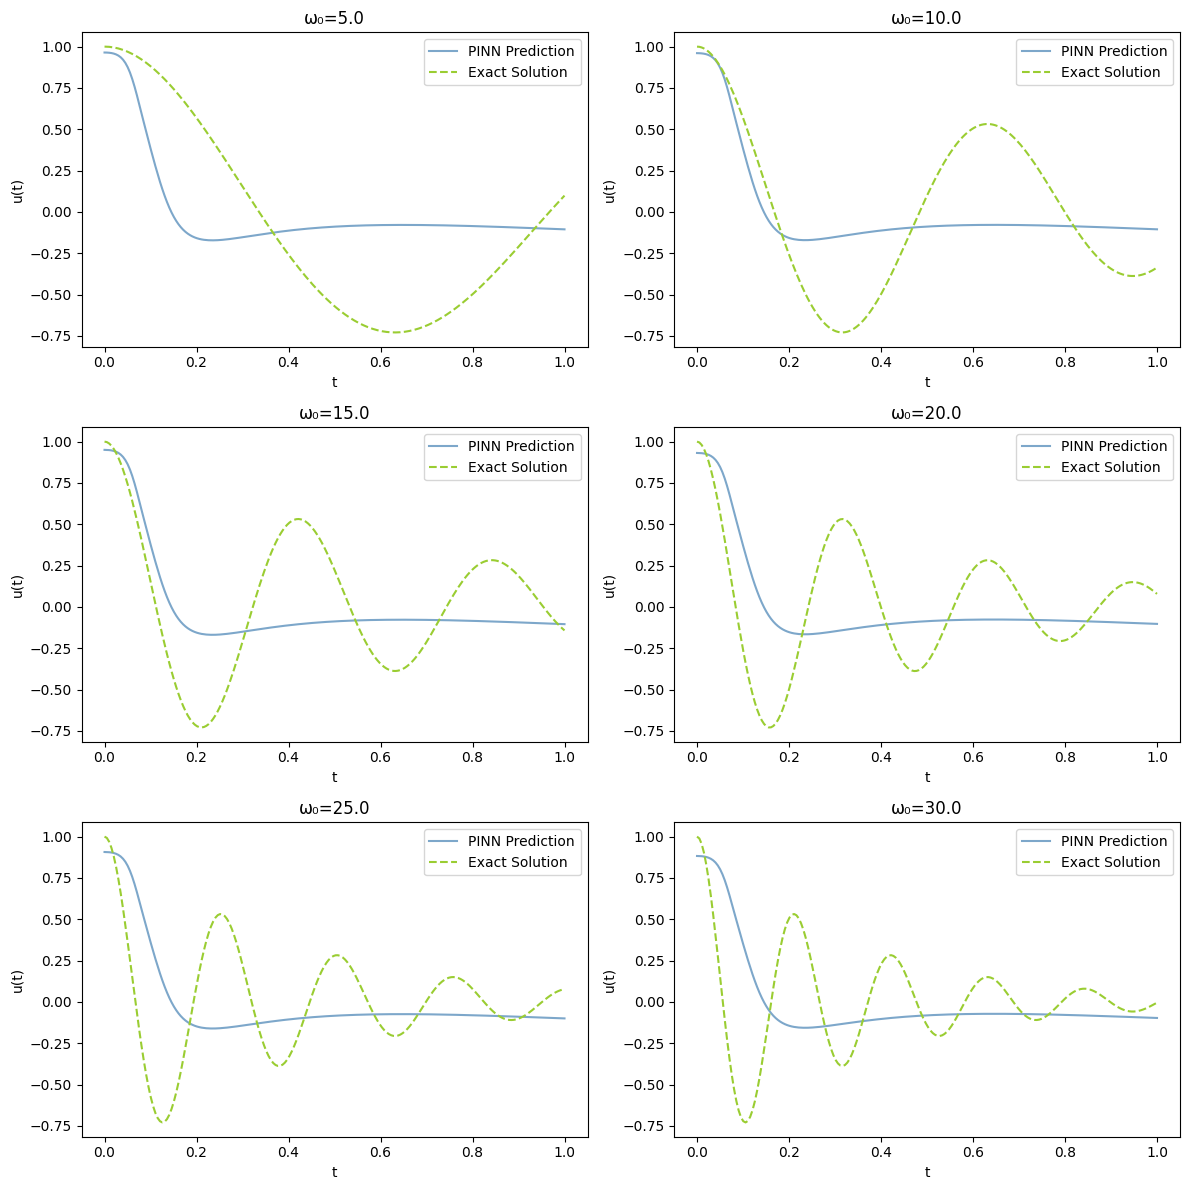

In [ ]:
@torch.no_grad()
def evaluate_model(model, omega_vals, res=200):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model parameters
    t = torch.linspace(0, 1, res, device=device).view(-1, 1)  

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  
    axes = axes.flatten()  

    for idx, omega_0 in enumerate(omega_vals):
        omega = torch.tensor([[omega_0]], device=device).repeat(t.shape[0], 1)
        u_pred = model(t, omega).squeeze().cpu().numpy()
        u_real = analytical_solution(0.1, omega_0, t.cpu()).cpu().numpy()

        ax = axes[idx]
        ax.plot(t.cpu().numpy(), u_pred, label=f"PINN Prediction", color="steelblue", alpha=0.7)
        ax.plot(t.cpu().numpy(), u_real, linestyle='--', label=f"Exact Solution", color="yellowgreen")
        ax.set_xlabel("t")
        ax.set_ylabel("u(t)")
        ax.legend()
        ax.set_title(f"ω₀={omega_0}")

    for idx in range(len(omega_vals), len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout()
    plt.show()

# Define the omega samples for evaluation
omega_samples = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0]

best_model = load_best_model(model, best_model_state) # load the best model state
evaluate_model(best_model, omega_samples)

Seems like the prediction is really bad. Play with the hyperparameters to tune the network. See if you can improve the accuracy. 

You will see that it is not an easy task to tune the hyperparameters in this case. There are several reasons behind it, but the most dominant 2 of them are:
1. **Dimensionality**: Although we simplified the model, the dimensionality makes the problem hard to train.
2. **High Frequencies**: Neural networks are proven to be biased towards the low-frequency components. So they might struggle to learn the high-frequency information.

How can we improve the model and get reasonable predictions then? The answer is: **Nondimensionalization and Fourier Features Encoding**.

### Nondimensionalization

Non-dimensionalization is a mathematical technique used to simplify equations by reducing the number of parameters and ensuring that the variables are expressed in terms of dimensionless quantities. This process not only reduces the complexity of the problem but also improves numerical stability and generalization. By scaling the variables appropriately, we can make the problem easier for the neural network to learn.

To nondimensionalize our equation:

$$
\ddot{u}(t) + 2\zeta \omega_0 \dot{u}(t) + \omega_0^2 u(t) = 0,
$$

we first have to define the non-dimensional variables:

1. **Dimensionless Time**:
   $$
   \bar{t} = \frac{t}{t^*}
   $$

2. **Dimensionless Displacement**:
   $$
   \bar{u} = \frac{u}{u^*}
   $$

$\bar{(\cdot{})}$ is a non-dimensional vaariable or parameter and $(\cdot{})^*$ refers to their scales. Then we can write the dimensional variables in terms of non-dimensional ones and their scales as:

$u = u^* \cdot \bar{u}$    and   $t = t^* \cdot \bar{t}$

We can then compute the derivatives of $u(t)$ with respect to $t$ in terms of $\bar{t}$:

1. First derivative:
   $$
   \dot{u}(t) = \frac{d u}{d t} = \frac{d (u^*  \bar{u})}{d (t^*\bar{t})} = \frac{u^*}{t^*} \frac{d \bar{u}}{d \bar{t}}.
   $$

Since $(\cdot{})^*$ are just scalars, we can take them out of derivaties. Then for the second derivative:

2. Second derivative:
   $$
   \ddot{u}(t) = \frac{d^2 u}{d t^2} = \frac{d^2 (u^* \bar{u})}{d (t^*\bar{t})^2} = \frac{u^*}{{t^*}^2} \frac{d^2 \bar{u}}{d \bar{t}^2}.
   $$

Now we can substitute these expressions into the original equation to get:

$$
\frac{u^*}{{t^*}^2} \cdot \frac{d^2 \bar{u}}{d \bar{t}^2} + 2\zeta \omega_0 \frac{u^*}{t^*} \cdot \frac{d \bar{u}}{d \bar{t}} +\omega_0^2 u^* \cdot \bar{u} = 0.
$$

Divide the equation by $\frac{u^*}{{t^*}^2}$

$$
\frac{d^2 \bar{u}}{d \bar{t}^2} + 2\zeta \omega_0 {t^*} \cdot \frac{d \bar{u}}{d \bar{t}} +\omega_0^2{t^*}^2 \cdot \bar{u} = 0.
$$

And lastly we can choose the scales for the variables, this is very important we want to get rid of as many parameters and dimensions as possible. $\zeta$ is already a dimensionless ratio, so only dimension here left are $t^*$ and $\omega_0$. if we choose $t^* = 1/\omega_0$. Equation reduces to:

$$
\frac{d^2 \bar{u}}{d \bar{t}^2} + 2\zeta \cdot \frac{d \bar{u}}{d \bar{t}} + \bar{u} = 0.
$$

Which makes our equation dimensionless!


### Fourier Features Encoding

Fourier Features Encoding is a technique introduced in the paper **"Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains"** by Tancik et al. (2020). This method is designed to help neural networks learn high-frequency functions more effectively, addressing the inherent bias of neural networks toward low-frequency components.

### How Fourier Features Work

Given an input vector $\mathbf{x} \in \mathbb{R}^d$, the Fourier Features Encoding maps it to a higher-dimensional space using sine and cosine functions:

$$
\gamma(\mathbf{x}) = \left[\sin(2\pi \mathbf{B} \mathbf{x}), \cos(2\pi \mathbf{B} \mathbf{x})\right],
$$

where:
- $\mathbf{B} \in \mathbb{R}^{m \times d}$ is a matrix of random frequencies, typically sampled from a Gaussian distribution with variance $\sigma^2$.
- $m$ is the number of Fourier features (i.e., the dimensionality of the transformed space).

The resulting encoding $\gamma(\mathbf{x})$ has a dimensionality of $2m$, as it concatenates both sine and cosine components.

In [53]:
# fourier encoding layer
class FourierEncoding(nn.Module):
    def __init__(self, in_features, num_frequencies, sigma=0.6):
        super().__init__()
        B = sigma * torch.randn(num_frequencies, in_features)
        self.register_buffer("B", B)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B.T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Define the non dimensional loss function for the ODE
def loss_ode_non_dim(model, t_bar, omega):
    t_bar.requires_grad_(True)
    omega.requires_grad_(True)

    u_bar = model(t_bar, omega)
    u_t_bar = torch.autograd.grad(u_bar, t_bar, grad_outputs=torch.ones_like(u_bar), create_graph=True)[0]
    u_tt_bar = torch.autograd.grad(u_t_bar, t_bar, grad_outputs=torch.ones_like(u_t_bar), create_graph=True)[0]

    residual = u_tt_bar + 2 * 0.1 * u_t_bar + u_bar
    return torch.mean(torch.square(residual))

Then we can use this fourier feaures encoding layer as the first layer of the trunk network. And also define the architecture. This time lets use a narrower network for both trunk and branch. Also lets choose only 1 branch-trunk pair. Overall significantly simpler model than previous one which failed. 

In [54]:
fourier_features = 100

branch_arch = [1] + [16] * 3 + [1]  # input_dim=1, hidden_dim=64, output_dim=1, depth=3
branch_act = nn.Tanh 
trunk_arch = [2*fourier_features] + [16] * 3 + [1]  # input_dim= 200 because we have 100 sine and 100 cosine features, hidden_dim=16, output_dim=1, depth=3
trunk_act = nn.Tanh

m = 1  # number of branches and trunks

branches_fourier = [MLP(branch_arch, branch_act) for _ in range(m)]    # creates a list of m branch networks all same architecture
trunks_fourier = [nn.Sequential(FourierEncoding(1, fourier_features), MLP(trunk_arch, trunk_act)) for _ in range(m)]

model_fourier = ParametricModel(branches_fourier, trunks_fourier)  # combine branch and trunk networks into a single model with Fourier encoding

In [56]:
# Training loop as before but with the sclaed variables and fourier encoding
def train_parametric_non_dimensional(model, num_iter=1000, num_collocation=128, num_omegas=10, lr=1e-3, device="cpu", ode_weight=1.0, ic_weight=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    best_loss = float('inf')  
    best_model_state = None  
    model = model.to(device)

    model.train()
    for i in range(num_iter):
        t = torch.rand(num_collocation, 1, device=device)  # torch.rand generates random numbers in [0, 1)
        omegas = torch.rand(num_omegas, 1, device=device) * 29 + 1  # generates random numbers in [0, 1), and then scal it to [1, 30)
        
        t_rep = t.repeat(num_omegas, 1)
        omegas_rep = omegas.repeat_interleave(num_collocation, dim=0)

        t_star = 1 / omegas_rep  # non-dimensional time
        t_bar = t_rep / t_star

        ode_loss = loss_ode_non_dim(model, t_bar, omegas_rep)
        ic_loss = loss_ic(model, omegas_rep)

        total_loss = ode_weight * ode_loss + ic_weight * ic_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())

        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_model_state = model.state_dict() 

        if i % 1000 == 0:
            print(f"Iter {i}, loss {total_loss.item():.3e}, ODE Loss {ode_loss.item():.3e}, IC Loss {ic_loss.item():.3e}")
    return model, losses, best_model_state

In [57]:
# train the model with Fourier encoding
model_fourier, losses_fourier, best_model_state_fourier = train_parametric_non_dimensional(model_fourier, num_iter=10000, num_collocation=128, num_omegas=10, lr=1e-3, device=device)

Iter 0, loss 1.052e+00, ODE Loss 3.726e-02, IC Loss 1.015e+00
Iter 1000, loss 9.839e-04, ODE Loss 9.484e-04, IC Loss 3.543e-05
Iter 2000, loss 2.562e-04, ODE Loss 2.554e-04, IC Loss 8.056e-07
Iter 3000, loss 8.393e-05, ODE Loss 7.982e-05, IC Loss 4.112e-06
Iter 4000, loss 1.187e-03, ODE Loss 1.178e-03, IC Loss 8.615e-06
Iter 5000, loss 2.588e-04, ODE Loss 2.567e-04, IC Loss 2.070e-06
Iter 6000, loss 3.797e-04, ODE Loss 3.794e-04, IC Loss 3.288e-07
Iter 7000, loss 4.864e-04, ODE Loss 4.861e-04, IC Loss 2.317e-07
Iter 8000, loss 2.048e-05, ODE Loss 2.034e-05, IC Loss 1.373e-07
Iter 9000, loss 6.399e-05, ODE Loss 6.389e-05, IC Loss 1.010e-07


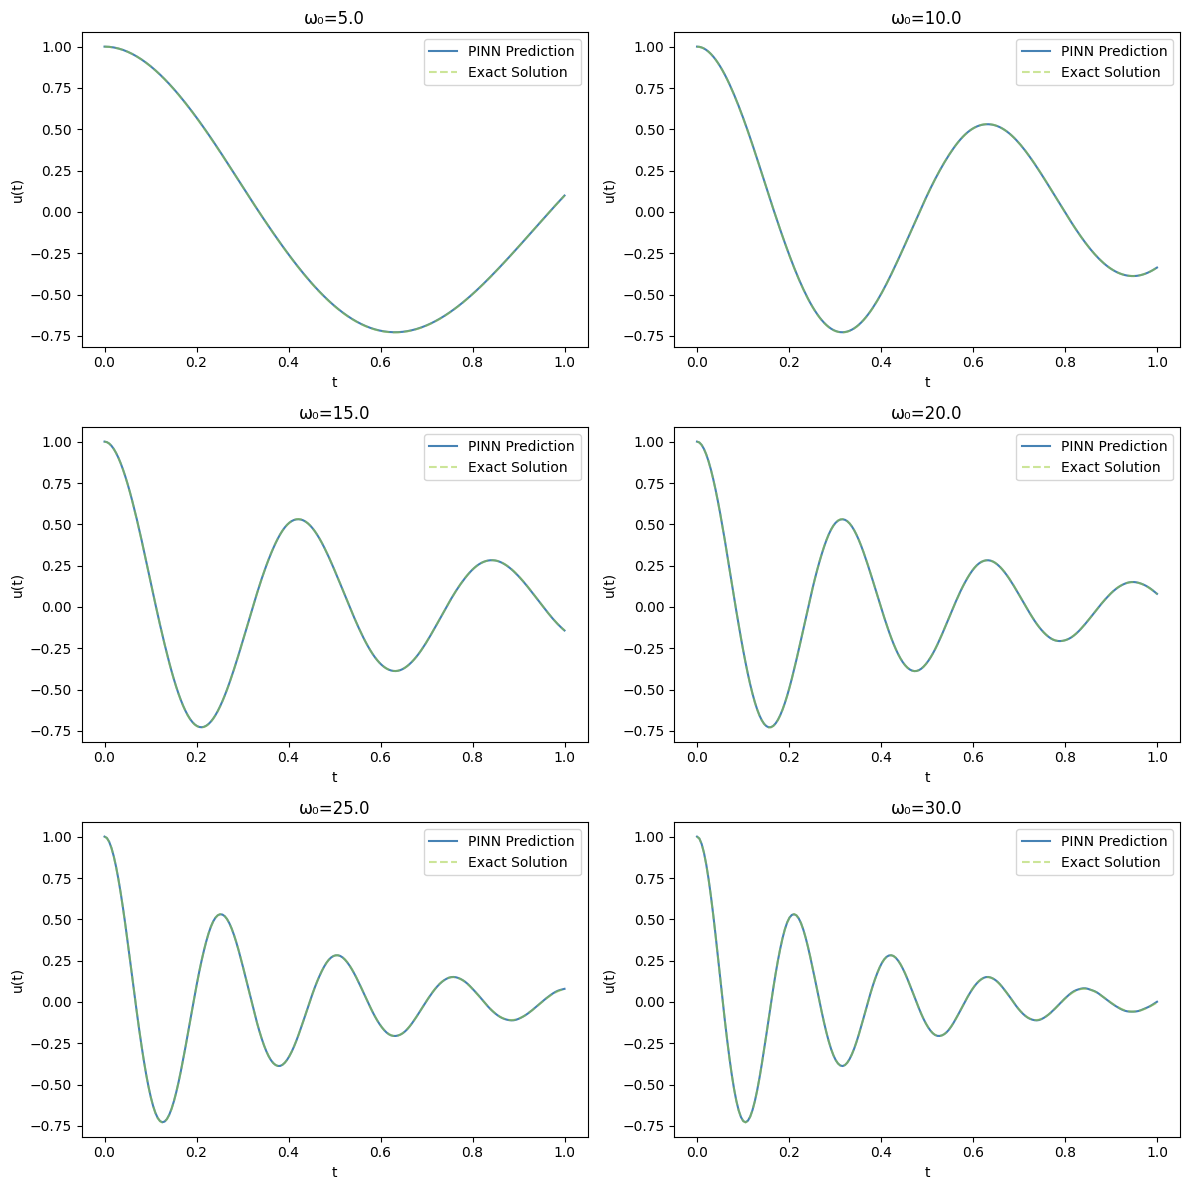

In [61]:
zeta = 0.1  # damping ratio

# Evaluate the model with the non-dimensional time and Fourier encoding
@torch.no_grad()
def evaluate_nondim_model(model, omega_vals, res=200):
    model.eval()
    device = next(model.parameters()).device
    t = torch.linspace(0, 1, res, device=device).view(-1, 1)  

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  
    axes = axes.flatten()  

    for idx, omega_0 in enumerate(omega_vals):
        omega = torch.tensor([[omega_0]], device=device).repeat(t.shape[0], 1)
        t_bar = t / (1 / omega_0)
        u_pred = model(t_bar, omega).squeeze().cpu().numpy()
        u_real = analytical_solution(zeta, omega_0, t.cpu()).cpu().numpy()

        ax = axes[idx]
        ax.plot(t.cpu().numpy(), u_pred, label=f"PINN Prediction", color="steelblue", alpha=1)
        ax.plot(t.cpu().numpy(), u_real, linestyle='--', label=f"Exact Solution", color="yellowgreen", alpha=0.5)
        ax.set_xlabel("t")
        ax.set_ylabel("u(t)")
        ax.legend()
        ax.set_title(f"ω₀={omega_0}")

    for idx in range(len(omega_vals), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

best_model_fourier = load_best_model(model_fourier, best_model_state_fourier) # load the best model state

omega_samples = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0]
evaluate_nondim_model(best_model_fourier, omega_samples)

**Voilà!** Prediction is in perfect agrement with the exact solution. You can see the drastic effect of non-dimensionalization and fourier features encoding. Employing these methods simplified the problem significantly and a simpler model could even learn the relation and have proper predictions. 

### References
- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045

- Moseley, B. So what is a physics-informed neural network? https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

- Tancik, M., Srinivasan, P. P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. T., & Ng, R. (2020). Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains. Advances in Neural Information Processing Systems (NeurIPS). https://arxiv.org/abs/2006.10739